In [1]:
%pip install -q segmentation_models
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Segmentation Models: using `tf.keras` framework.


In [2]:
from tensorflow import keras

keras.backend.set_image_data_format('channels_last')
%pip install graphviz
import os
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import graphviz
import keras
import datetime
# Data
from keras import backend as K
from tqdm import tqdm

print(os.getcwd())

# Data Viz
import matplotlib.pyplot as plt
import gc

from sklearn.model_selection import train_test_split

# Model
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Dense
# Callbacks
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# %pip install -qU albumentations[imgaug]
# %pip install -qU imgaug
# import albumentations as A
import tensorflow_addons as tfa

%pip install -qU tf_explain
from tf_explain.core.grad_cam import GradCAM

import cv2
from keras.metrics import MeanIoU

Note: you may need to restart the kernel to use updated packages.
/kaggle/working


/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Note: you may need to restart the kernel to use updated packages.


In [3]:
# df = pd.read_csv("/kaggle/input/wounds/description.csv")
# df["Path to files"] = df["Path to files"].apply(lambda x: os.path.join(dir,x).replace("\\","/"))
# df.head()

# i = df['Path to files'][0]
# image = tf.keras.utils.load_img(os.path.join(i,'photo.jpg'))
# input_arr = tf.keras.utils.img_to_array(image)
# input_arr

# img_shape = (1224, 816)

# images = np.zeros((len(df), img_shape[0], img_shape[1], 3))
# masks = np.zeros((len(df), img_shape[0], img_shape[1], 1))

# for idx,i in tqdm(enumerate(df['Path to files'])):
#   image = tf.keras.utils.load_img(os.path.join(i,'photo.jpg'), target_size=img_shape,  method="lanczos")
#   input_arr = tf.keras.utils.img_to_array(image) / 255.
#   images[idx] = input_arr
#   image = tf.keras.utils.load_img(os.path.join(i,'mask.png'), color_mode="grayscale" , target_size=img_shape, method="lanczos")
#   input_arr = tf.keras.utils.img_to_array(image) / 255.
#   masks[idx] = input_arr

# os.path.join(dir,"images.npy")

# with open(os.path.join(dir,"images.npy"), 'wb') as f:
#   np.save(f,images)

# with open(os.path.join(dir,"masks.npy"), 'wb') as f:
#   np.save(f,masks)

# masks = np.load(os.path.join(dir,"masks.npy"))
# images = np.load(os.path.join(dir,"images.npy"))


# images = np.load("/kaggle/input/wounds/images.npy")
# masks = np.load("/kaggle/input/wounds/masks.npy")

# train_idx, test_idx = train_test_split(range(len(df)), test_size=0.1, random_state=50)

# train_dataset = tf.data.Dataset.from_tensor_slices((images[train_idx],masks[train_idx]))
# test_dataset  = tf.data.Dataset.from_tensor_slices((images[test_idx],  masks[test_idx]))

In [4]:
img_shape = [128,128,3]
# img_shape = [160,160,3]

In [5]:
def brightness_contrast(image):
    image = tf.image.random_brightness(image, 0.3)
    image = tf.image.random_contrast(image, 0.7, 1.3)
    return image
    
def rotate(image, mask):
    angle1 = tf.random.uniform(shape=[])*45
    image1 = tfa.image.rotate(image, np.pi/360*angle1)
    mask1  = tfa.image.rotate(mask, np.pi/360*angle1)
    
    angle2 = tf.random.uniform(shape=[])*-45
    image2 = tfa.image.rotate(image, np.pi/360*angle2)
    mask2  = tfa.image.rotate(mask, np.pi/360*angle2)
    
    angle3 = tf.random.uniform(shape=[])*45
    image3 = tfa.image.rotate(image, np.pi/360*angle3)
    mask3  = tfa.image.rotate(mask, np.pi/360*angle3)
    
    angle4 = tf.random.uniform(shape=[])*-45
    image4 = tfa.image.rotate(image, np.pi/360*angle4)
    mask4  = tfa.image.rotate(mask, np.pi/360*angle4)
    
    return [image1, image2, image3, image4], [mask1, mask2, mask3, mask4]
#     return [image1, image2], [mask1, mask2]
    
    
def centre_crop(image, mask):
    amount = tf.random.uniform(shape=[])*0.6+0.4
    image  = tf.image.central_crop(image, amount)
    mask   = tf.image.central_crop(mask, amount)
    return image, mask
    
def resize(image, mask): 
    image = tf.image.resize(image, img_shape[:2], method = "lanczos3")
    mask  = tf.image.resize( mask, img_shape[:2], method = "lanczos3") 
    image =  (image - np.min(image)) / (np.max(image)-np.min(image))
    if np.max(mask)>np.min(mask):
        mask =  (mask - np.min(mask)) / (np.max(mask)-np.min(mask))
        mask = tf.cast(mask>0.5, tf.float32)
    else:
        mask = np.zeros_like(mask)

    return image, mask

def aug(image, mask, augment = True):
    if augment == True:
        image1 = image
        mask1 = mask

        image2 = tf.image.flip_left_right(image)
        mask2  = tf.image.flip_left_right(mask)

        image3 = tf.image.flip_up_down(image)
        mask3  = tf.image.flip_up_down(mask)

        image4 = tf.image.flip_left_right(image)
        mask4  = tf.image.flip_left_right(mask)
        image4 = tf.image.flip_up_down(image4)
        mask4  = tf.image.flip_up_down(mask4)

        images = [image1, image2, image3, image4]
        masks = [mask1, mask2, mask3, mask4]
        
        
        for i in range(4):
            demoimage, demomask = rotate(images[i], masks[i])
            images += demoimage
            masks += demomask
        
        for i in range(len(images)):
            images[i] = brightness_contrast(images[i])
            images[i], masks[i] = centre_crop(images[i], masks[i])
            images[i], masks[i] = resize(images[i], masks[i])
    
    images = images
    masks = masks
    return {'images':images, 'masks':masks}

In [6]:
def get_data(path, labels_present=True, adjust_labels = False, augment = True, change_mask = False):
    size = len(os.listdir(os.path.join(path,"images")))
    
    images = []
    if labels_present:
        masks = []

    for idx,i in enumerate(tqdm(os.listdir(os.path.join(path,"images")))):
        image = tf.keras.utils.load_img(os.path.join(path,"images",i))
        image = tf.keras.utils.img_to_array(image)
        y_nonzero, x_nonzero, _ = np.nonzero(image)
        image = image[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]
        if labels_present:
            mask = tf.keras.utils.load_img(os.path.join(path,"labels",i), color_mode="grayscale")
            mask = tf.keras.utils.img_to_array(mask)
            mask = mask[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]
            
            if change_mask==True:
                mask=mask*255
            
            if augment:
                sample = aug(image=image, mask=mask)                    
                masks+= sample['masks']
                images+= sample['images']
            else:
                image = tf.image.resize(image, img_shape[:2], method = "lanczos3")
                mask  = tf.image.resize( mask, img_shape[:2], method = "lanczos3") 
                image =  (image - np.min(image)) / (np.max(image)-np.min(image))
                if np.max(mask)>np.min(mask):
#                     mask =  (mask - np.min(mask)) / (np.max(mask)-np.min(mask))
                    mask = tf.cast(mask>0.5, tf.float32)
                else:
                    mask = np.zeros_like(mask)
                images += [image]
                masks += [mask]
                
        else:
            image = tf.image.resize(image, img_shape[:2], method = "lanczos3") 
            image =  (image - np.min(image)) / (np.max(image)-np.min(image))
            images+=[image]
        
    if labels_present:
        return (np.array(images),np.array(masks))
    else:
        return np.array(images)

In [7]:
# train_images, train_masks = get_data("/kaggle/input/wounds/Foot Ulcer Segmentation Challenge/train")
# validation_images, validation_masks = get_data("/kaggle/input/wounds/Foot Ulcer Segmentation Challenge/validation", augment = False)

# test_images1 = get_data("/kaggle/input/wounds/Foot Ulcer Segmentation Challenge/test", labels_present = False)

# train_images, train_masks = get_data("/kaggle/input/wounds/Medetec_foot_ulcer_224/train", change_mask=True)
# validation_images, validation_masks = get_data("/kaggle/input/wounds/Medetec_foot_ulcer_224/test", augment = False, change_mask=True)

In [8]:
train_images, train_masks = get_data("/kaggle/input/wounds/azh_wound_care_center_dataset_patches/train")
validation_images, validation_masks = get_data("/kaggle/input/wounds/azh_wound_care_center_dataset_patches/test", augment = False)


100%|██████████| 278/278 [00:06<00:00, 45.22it/s]


In [9]:
# train_images = np.concatenate([train_images, train_images2])
# # train_masks = np.concatenate([train_masks, train_masks2])

# validation_images = np.concatenate([validation_images, validation_images2])
# validation_masks = np.concatenate([validation_masks, validation_masks2])

gc.collect()

0

In [11]:
pth = "OnlyAHZOld"
os.mkdir(f"{pth}")
os.mkdir(f"{pth}/train")
os.mkdir(f"{pth}/validation")
os.mkdir(f"{pth}/train/images")
os.mkdir(f"{pth}/train/masks")
os.mkdir(f"{pth}/validation/images")
os.mkdir(f"{pth}/validation/masks")

idx = np.arange(len(train_images))
for place,i in enumerate(tqdm(np.arange(len(train_images)))):
    tf.keras.utils.save_img(f"{pth}/train/images/{idx[place]}.png", train_images[i], scale=True, data_format="channels_last")
    tf.keras.utils.save_img(f"{pth}/train/masks/{idx[place]}.png", train_masks[i], scale=True, data_format="channels_last")

idx = np.arange(len(validation_images))
for place, i in enumerate(tqdm(np.arange(len(validation_images)))):
    tf.keras.utils.save_img(f"{pth}/validation/images/{idx[place]}.png", validation_images[i], scale=True, data_format="channels_last")
    tf.keras.utils.save_img(f"{pth}/validation/masks/{idx[place]}.png", validation_masks[i], scale=True, data_format="channels_last")

100%|██████████| 278/278 [00:02<00:00, 113.98it/s]


In [12]:
def show_image(image, title=None):
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.3,title=None):
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

# **Loss Functions**

In [13]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) +smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg +(1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)


def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    IoU=(intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)
    return IoU

def jacard_coef_loss(y_true, y_pred):
    IoU = jacard_coef(y_true, y_pred)
    return -IoU



# **Custom Callback**

In [14]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        id = np.random.randint(train_images.shape[0])
        image = train_images[id]
        mask = train_masks[id]
        pred_mask = self.model.predict(image[np.newaxis,...])>0.5
#         exp = GradCAM()
#         cam = exp.explain(
#             validation_data=(image[np.newaxis,...], mask),
#             class_index=1,
#             layer_name='Attention4',
#             model=self.model
#         )

        plt.figure(figsize=(8,6))
        plt.subplot(1,2,1)
        plt.title("Original Mask ")
        show_mask(image, mask, cmap='binary',alpha=0.5)

        plt.subplot(1,2,2)
        plt.title("Predicted Mask ")
        show_mask(image, pred_mask[0], cmap='binary',alpha=0.5)

#         plt.subplot(1,3,3)
#         show_image(cam,title="GradCAM")

        plt.tight_layout()
        plt.show()

In [15]:
def plot_results(results):
    loss,dice_coef,precision,recall,val_loss,val_dice_coef,val_precision,val_recall=results.history.values()
    plt.figure(figsize=(20,10))
    plt.style.use("ggplot")

    plt.subplot(2,2,1)
    plt.title("Loss")
    plt.plot(loss, label="Training")
    plt.plot(val_loss, label="Validation")
    plt.legend()
    plt.grid()

    plt.subplot(2,2,2)
    plt.title("Dice Coef")
    plt.plot(dice_coef, label="Training")
    plt.plot(val_dice_coef, label="Validation")
    plt.legend()
    plt.grid()

    plt.subplot(2,2,3)
    plt.title("Precision")
    plt.plot(precision, label="Training")
    plt.plot(val_precision, label="Validation")
    plt.legend()
    plt.grid()

    plt.subplot(2,2,4)
    plt.title("Recall")
    plt.plot(recall, label="Training")
    plt.plot(val_recall, label="Validation")
    plt.legend()
    plt.grid()

    plt.show()

| id | Model             |Dice |
| ---|---                |---  |
|  0   |  resnet 18        | 84  | 
|  1   |  resnet 34        | 85  | 
|  2   |  resnet 50        | 86  | 
|  3   |  resnet 101       | 83  | 
|  4   |  resnet 152       | 82? | 
|  5   |  serestnet18      |   | 
|  6   |  serestnet34      | 84  | 
|  7   |  serestnet50      | 88  | 
|  8   |  serestnet101     |   |
|  9   |  serestnet152     | 88  |
|  10  |  serestnext50     |   |
|  11  |  serestnext101    | 86  |
|  12  |  senet154         |   |
|  13  |  resnext50        |   |
|  14  |  resnext101       | 87  |
|  15  |  vgg16            |   |
|  16  |  vgg19            |   |
|  17  |  densenet121      | 87  |
|  18  |  densenet169      |   |
|  19  |  densnet201       |   |
|  20  |  inceptionresnetv2|   |
|  21  |  inceptionv3      |   |
|  22  |  mobilenet        |   |
|  23  |  mobilenetv2      |   |
|  24  |  efficientnetb0   |   |
|  25  |  efficientnetb1   |   |
|  26  |  efficientnetb2   |   |
|  27  |  efficientnetb3   |   |
|  28  |  efficientnetb4   |   |
|  29  |  efficientnetb5   |   |
|  30  |  efficientnetb6   |   |
|  31  |  efficientnetb7   |   |


In [16]:
# model = sm.Linknet(input_shape=img_shape, classes=1, activation='sigmoid')

backbones = {0: 'resnet18', 1: 'resnet34', 2: 'resnet50', 3: 'resnet101', 4: 'resnet152',
 5: 'seresnet18', 6: 'seresnet34', 7: 'seresnet50', 8: 'seresnet101', 9: 'seresnet152',
 10: 'seresnext50', 11: 'seresnext101', 12: 'senet154',
 13: 'resnext50', 14: 'resnext101',
 15: 'vgg16', 16: 'vgg19',
 17: 'densenet121', 18: 'densenet169', 19: 'densenet201',
 20: 'inceptionresnetv2', 21: 'inceptionv3',
 22: 'mobilenet', 23: 'mobilenetv2',
 24: 'efficientnetb0', 25: 'efficientnetb1', 26: 'efficientnetb2', 27: 'efficientnetb3', 28: 'efficientnetb4', 29: 'efficientnetb5', 30: 'efficientnetb6', 31: 'efficientnetb7'}


# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# instantiate a distribution strategy
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
# with tpu_strategy.scope():

model = sm.FPN(backbone_name=backbones[9],input_shape=img_shape, classes=1, activation='sigmoid')

# l2 = tf.keras.regularizers.l2(1e-5)
# for layer in model.layers:
#     if hasattr(layer, 'kernel'):
# #     if isinstance(layer, tf.keras.layers.Conv2D):
#         model.add_loss(lambda layer=layer: l2(layer.kernel))

# Compile
model.compile(
    loss=dice_coef_loss,
    optimizer=tf.optimizers.Adam(learning_rate=0.00001),
    metrics=[dice_coef,tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],
)

# Callback
log_dir = "logs/fit/" + str(datetime.datetime.now())

# model.load_weights("/kaggle/input/onlysegmentationweightsh5/OnlySegmentationWeights.h5")

# model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=64, expand_nested=True)


261385016/261385016 [==============================] - 3s 0us/step


In [17]:
# pathx = "/kaggle/input/wounds/FUSEGnew"
# pathx = "WoundSegOld"
pathx= "OnlyAHZOld"
def train_series():
    path = f"{pathx}/train/"
    for i in os.listdir(path+"images"):
        image = tf.keras.utils.img_to_array(tf.keras.utils.load_img(path+"images/"+i)) / 255.
        mask = tf.keras.utils.img_to_array(tf.keras.utils.load_img(path+"masks/"+i, color_mode="grayscale")) / 255.
        yield tf.convert_to_tensor(image),tf.convert_to_tensor(mask)

def validation_series():
    path = f"{pathx}/validation/"
    for i in os.listdir(path+"images"):
        image = tf.keras.utils.img_to_array(tf.keras.utils.load_img(path+"images/"+i)) /255.
        mask = tf.keras.utils.img_to_array(tf.keras.utils.load_img(path+"masks/"+i, color_mode="grayscale")) /255.
        yield tf.convert_to_tensor(image),tf.convert_to_tensor(mask)

train_gen = tf.data.Dataset.from_generator(
    train_series, 
    output_signature=(
         tf.TensorSpec(shape=img_shape, dtype=tf.float32),
         tf.TensorSpec(shape=img_shape[:2]+[1], dtype=tf.float32)),
    ).batch(16).prefetch(3)
# 16200

val_gen = tf.data.Dataset.from_generator(
    validation_series, 
    output_signature=(
         tf.TensorSpec(shape=img_shape, dtype=tf.float32),
         tf.TensorSpec(shape=img_shape[:2]+[1], dtype=tf.float32))
).batch(16).prefetch(3)
# 200

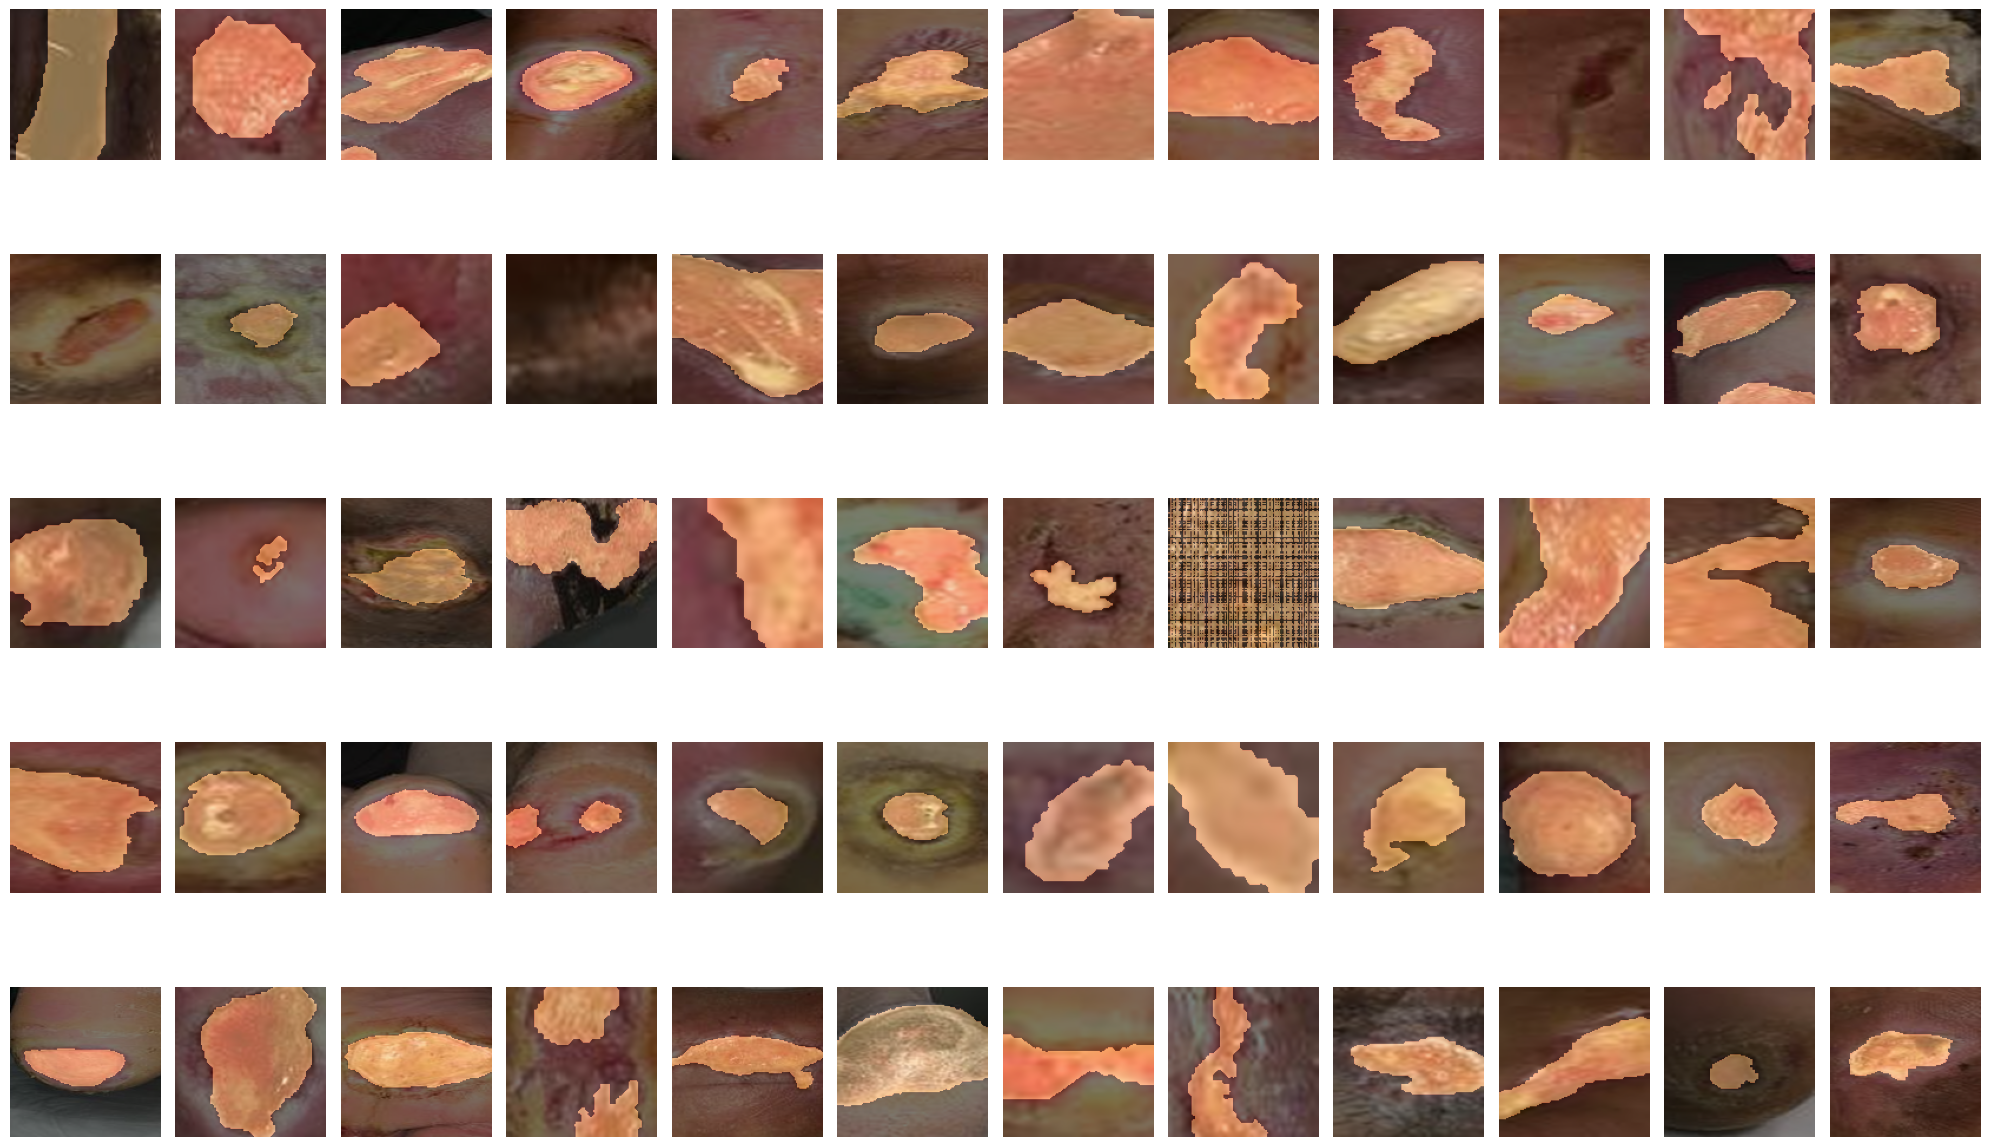

In [18]:
demo = iter(train_series())
plt.figure(figsize=(20,13))
for i in range(60):
    plt.subplot(5,12,i+1)
    image, mask = next(demo)
    show_mask(image, mask, cmap='copper',alpha=0.5) # binary afmhot copper
#     show_image(train_images[i]) 
    
plt.tight_layout()
plt.show()

# **Training**

In [19]:
gc.collect()

122766

In [20]:
cb = [
    ModelCheckpoint("BestModel.h5", save_best_only=True, monitor = "val_loss"),
#      ShowProgress(),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
    EarlyStopping(patience=3, restore_best_weights=True)
]

results = model.fit(
  train_gen,
  epochs=25,
  callbacks=cb,
  validation_data= val_gen)

# results = model.fit(
#   train_images, train_masks,
#   epochs=25,
#   batch_size= 8,
#   callbacks=cb,
#   validation_data= (validation_images, validation_masks),
# )
gc.collect()
plot_results(results)

Epoch 1/25
208/208 [==============================] - 226s 386ms/step - loss: 0.3002 - dice_coef: 0.6999 - precision: 0.6302 - recall: 0.8905 - val_loss: 0.2709 - val_dice_coef: 0.7269 - val_precision: 0.7573 - val_recall: 0.8313
Epoch 2/25
208/208 [==============================] - 74s 358ms/step - loss: 0.1593 - dice_coef: 0.8407 - precision: 0.8378 - recall: 0.9070 - val_loss: 0.2278 - val_dice_coef: 0.7698 - val_precision: 0.8254 - val_recall: 0.7950
Epoch 3/25
208/208 [==============================] - 74s 355ms/step - loss: 0.1102 - dice_coef: 0.8898 - precision: 0.8979 - recall: 0.9298 - val_loss: 0.2205 - val_dice_coef: 0.7767 - val_precision: 0.8630 - val_recall: 0.7591
Epoch 4/25
208/208 [==============================] - 76s 365ms/step - loss: 0.0874 - dice_coef: 0.9126 - precision: 0.9212 - recall: 0.9415 - val_loss: 0.2177 - val_dice_coef: 0.7806 - val_precision: 0.8833 - val_recall: 0.7382
Epoch 5/25
208/208 [==============================] - 74s 354ms/step - loss: 0.0747

KeyboardInterrupt: 

In [ ]:
# !zip -r -q MODEL.zip BestModel.h5
# from IPython.display import FileLink
# FileLink(r'MODEL.zip')

In [ ]:
model2 = sm.FPN(backbone_name=backbones[7],input_shape=img_shape, classes=1, activation='sigmoid')

# l2 = tf.keras.regularizers.l2(1e-5)
# for layer in model.layers:
#     if hasattr(layer, 'kernel'):
# #     if isinstance(layer, tf.keras.layers.Conv2D):
#         model.add_loss(lambda layer=layer: l2(layer.kernel))



# Compile
model2.compile(
    loss=dice_coef_loss,
    optimizer=tf.optimizers.Adam(learning_rate=0.00001),
    metrics=[dice_coef,tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],
)

model2.load_weights("BestModel.h5")


In [ ]:
model2.evaluate(eval_gen)

In [ ]:
demo = model.predict(train_images[:10])

plt.figure(figsize=(20,13))
for i in range(10):
    plt.subplot(5,8,i+1)
    id = np.random.randint(len(train_images))
    show_mask(train_images[i], demo[i]>0.5, cmap='binary',alpha=0.5) # binary afmhot copper

plt.tight_layout()
plt.show()

In [ ]:
model.save_weights("Segmentation.h5")

# **Evaluation**

In [ ]:
# loss,segmentation_loss,prediction_loss,segmentation_accuracy,segmentation_IoU,prediction_accuracy,\
# val_loss,val_segmentation_loss,val_prediction_loss,val_segmentation_accuracy,val_segmentation_IoU,val_prediction_accuracy=


In [ ]:
plt.figure(figsize=(18,12))
n=0
for i in range(1,(4*6)+1):
    plt.subplot(4,6,i)
    if n==0:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis,...])
        show_mask(image, mask,title="Original Mask: "+labels_name[np.argmax(labels[id])],alpha=0.6, cmap='copper')
        n+=1
    elif n==1:
        show_mask(image, tf.cast(pred_mask>0.5,tf.float32), title="Predicted Mask:",alpha=0.6,cmap='copper')
        n+=1

    elif n==2:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis,...])
        show_mask(image, mask,title="Original Mask: "+labels_name[np.argmax(labels[id])],alpha=0.6, cmap='copper')
        n+=1
    elif n==3:
        show_mask(image, tf.cast(pred_mask>0.5,tf.float32), title="Predicted Mask:",alpha=0.6,cmap='copper')
        n+=1

    elif n==4:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask = model.predict(image[np.newaxis,...])
        show_mask(image, mask,title="Original Mask: "+labels_name[np.argmax(labels[id])],alpha=0.6, cmap='copper')
        n+=1
    else:
        show_mask(image, tf.cast(pred_mask>0.5,tf.float32), title="Predicted Mask:",alpha=0.6,cmap='copper')
        n=0

plt.tight_layout()
plt.show()